In [1]:
# import statements
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pingouin as pg
import toolbox
from scipy import interpolate
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.tsa.stattools import acf


# set color bar
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255),
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# get ozone data from SWOOSH 'combined o3q'
o3_data = xr.open_dataset('/home/disk/pna2/aodhan/MLS/MLS_O3/swoosh-v02.7-198401-202312-latpress-2.5deg-L31.nc').combinedo3q
o3_data_values = o3_data.sel(time=slice('2002-01-01', '2022-12-31')).values
o3_calendar = np.reshape(o3_data_values, (21, 12, 31, 72))

# turn to percent anomaly relative to 2002-2022 mean
o3_climatology = np.nanmean(o3_calendar, axis=0)
o3_anomalies = o3_calendar - o3_climatology
o3_anomalies_percent = np.divide(o3_anomalies, o3_climatology)*100

# get anomalies timeseries
o3_anomalies_ts = np.reshape(o3_anomalies_percent, (21*12, o3_anomalies_percent.shape[2], o3_anomalies_percent.shape[3]))

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [3]:
def alt2pres(altitude):
    """
    Function to turn GNSS-RO derived tropopause height from Z coordinate
    to P coordinate.
    """
    
    H = 7 
    press = 1000*np.exp(-1*(altitude/H))
    return press

# turn lrz to lrp
lrz = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/tempmaps/lrz_maps_zm_annual_mean.npy')
lrp = alt2pres(lrz)

# interpolate lrp to the ozone latitudes for ease of plotting
lats_trop = np.arange(-87.5,87.51,5)
lats_o3 = o3_data.lat.values
interpolation_function = interpolate.interp1d(lats_trop, lrp, fill_value='extrapolate')
lrp_o3lats = interpolation_function(lats_o3)

In [4]:
# load ENSO and QBO indices
enso = pd.read_csv('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/meiv2_adjusted.data', sep="    ", header=None)
enso_calendar = [list(enso.iloc[i].values) for i in range(0,len(enso))][22:44]
enso_ts = np.ravel(enso_calendar)[9:-3]
qbo = pd.read_csv('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/QBO_EOF_coeff.txt', delim_whitespace=True)
qbo = qbo[(qbo['Year'] >= 2002) & (qbo['Year'] <= 2022)]
qbo_eof1 = qbo['EOF-1'].values
qbo_eof2 = qbo['EOF-2'].values

# do MLR regression
o3_anoms_No_QBO_ENSO = toolbox.ENSO_QBO_remover(o3_anomalies_ts, enso_ts, qbo_eof1, qbo_eof2)

# rearange the array and get trends
o3_anoms_No_QBO_ENSO_sx = np.swapaxes(o3_anoms_No_QBO_ENSO, 0,2)
o3_anoms_No_QBO_ENSO_sxx = np.swapaxes(o3_anoms_No_QBO_ENSO_sx, 1,2)

# get trends
map_of_trends = toolbox.annual_trend_finder(o3_anoms_No_QBO_ENSO_sxx)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pingouin/regression.py:410: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 3 with 4 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn('Design matrix supplied with `X` parameter is rank '
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pingouin/regression.py:435: RuntimeWarning: invalid value encountered in double_scalars
  adj_r2 = 1 - (1 - r2) * (n - constant) / df_resid
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pingouin/regression

# Plot 2002-2022 Ozone Trend

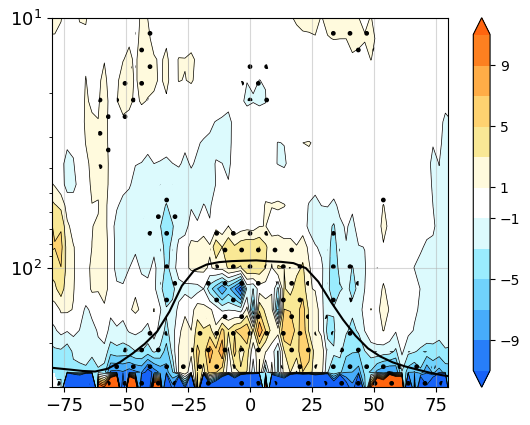

In [7]:
# define contouring levels
levels = np.arange(-0.55,0.551,.1)*20

# plot trend contour with colorbar
plt.contour(o3_data.lat, o3_data.level, map_of_trends[:,:,0], 
            levels=levels, colors='black', extend='both', 
            linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
im = plt.contourf(o3_data.lat, o3_data.level, map_of_trends[:,:,0], 
                  levels=levels, cmap=custom_cmap, extend='both')
cbar = plt.colorbar(im)
cbar.set_ticks(np.array([-0.45,-0.25, -0.05, 0.05, 0.25,0.45])*20)

# add significance
plt.contourf(o3_data.lat, o3_data.level, map_of_trends[:,:,1], 
             levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# add lapse-rate tropopause
plt.plot(lats_trop, lrp, color='black')

# set extra plotting parameters
plt.yscale('log')
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.xlim(-80,80)
plt.ylim(300,10)
plt.tick_params(axis='both', which='major', labelsize=13)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/SwooshColorBar', dpi=300)


# Correlation

In [8]:
# read in the AWLS timeseries
awls = np.load('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/AWLS.npy')

# get correlations
correlation_map, significance_map = toolbox.annual_corr_finder(o3_anoms_No_QBO_ENSO_sxx, awls)

/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:202: RuntimeWarning: invalid value encountered in sqrt
  t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))


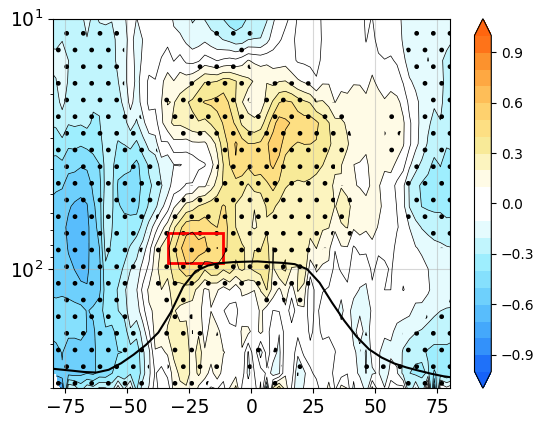

In [37]:
# set contour levels
levels = np.arange(-1,1.01,.1)

# plot correlation with colorbar
plt.contour(o3_data.lat, o3_data.level, correlation_map.T, 
            levels=levels, colors='black', extend='both', 
            linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.contourf(o3_data.lat, o3_data.level, correlation_map.T, 
             levels=levels, cmap=custom_cmap, extend='both')
plt.colorbar()

# add significance
plt.contourf(o3_data.lat, o3_data.level, significance_map.T, 
             levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# set tick params
plt.tick_params(axis='both', which='major', labelsize=13.5)
y_vals = np.array([100,10])
plt.yticks(y_vals)

# include grid and set range
plt.grid(alpha=0.5)
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylim(300,10)
plt.xlim(-80,80)

# include tropopause on plot
plt.plot(lats_trop, lrp, color='black')

# add rectangle for AWLS region
rect = patches.Rectangle((-33.75, 72), 22.5, 23, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)


# Circulation Regression

In [38]:
# do circulation projection
projection_timeseries, map_sig = toolbox.annual_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls)
projection_timeseries = np.swapaxes(projection_timeseries, 0,2)
projection_timeseries = np.swapaxes(projection_timeseries, 1,2)
residual = o3_anoms_No_QBO_ENSO_sxx - projection_timeseries

#find trends
map_of_trends = toolbox.annual_trend_finder(o3_anoms_No_QBO_ENSO_sxx)
map_of_trends_projection = toolbox.annual_trend_finder(projection_timeseries)
map_of_trends_residual = toolbox.annual_trend_finder(residual)

/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:265: RuntimeWarning: divide by zero encountered in double_scalars
  (1+r1_autocorrelation))
/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  t_stat_calculated = reg_coef/sa
/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  var_errors = (1/N_star)*sum_squared_error_res


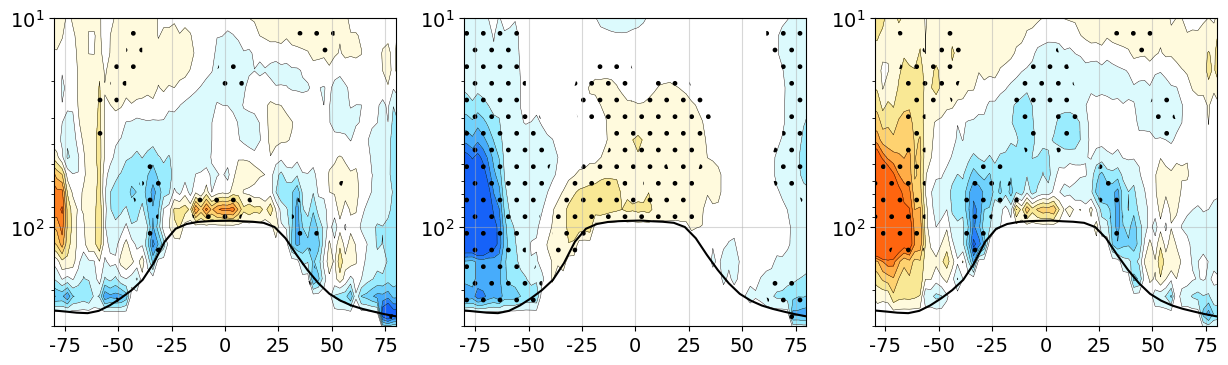

In [39]:
# set contour levels
levels = np.arange(-0.55,0.551,.1)*10

# define subplots
fig, axs = plt.subplots(1,3, figsize=(15,4))

# zero data below tropopause
trends_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                         0, map_of_trends[:,:,0])
trends_sig_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                             0, map_of_trends[:,:,1])
proj_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                       0, map_of_trends_projection[:,:,0])
proj_sig_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                           0, map_sig)
resid_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                        0, map_of_trends_residual[:,:,0])
resid_sig_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                            0, map_of_trends_residual[:,:,1])

# plot trends
axs[0].contour(o3_data.lat, o3_data.level, trends_masked, levels=levels, 
               colors='black', extend='both', linewidths=0.3, linestyles=np.where(levels >= 0, "-", "-"))
im = axs[0].contourf(o3_data.lat, o3_data.level, trends_masked, levels=levels, 
                     cmap=custom_cmap, extend='both')
axs[0].contourf(o3_data.lat, o3_data.level, trends_sig_masked, levels=[-1, 0, 1], 
                colors='none', hatches=[None,'.'])

# circulation regression
axs[1].contour(o3_data.lat, o3_data.level, proj_masked, levels=levels, 
               colors='black', extend='both', linewidths=0.3, linestyles=np.where(levels >= 0, "-", "-"))
axs[1].contourf(o3_data.lat, o3_data.level, proj_masked, levels=levels, 
                cmap=custom_cmap, extend='both')
axs[1].contourf(o3_data.lat, o3_data.level, proj_sig_masked, levels=[-1, 0, 1], 
                colors='none', hatches=[None,'.'])

# residual
axs[2].contour(o3_data.lat, o3_data.level, resid_masked, levels=levels, 
               colors='black', extend='both', linewidths=0.3, linestyles=np.where(levels >= 0, "-", "-"))
axs[2].contourf(o3_data.lat, o3_data.level, resid_masked, levels=levels, 
                cmap=custom_cmap, extend='both')
axs[2].contourf(o3_data.lat, o3_data.level, resid_sig_masked, levels=[-1, 0, 1], 
                colors='none', hatches=[None,'.'])

# for each subplot, fix plotting range, include lrz, etc...
for i in range(3):
    #rect = patches.Rectangle((-33.75, 80.), 15, 20, linewidth=2, edgecolor='red', facecolor='none')
    #axs[i].add_patch(rect)
    axs[i].set_xlim(-80,80)
    axs[i].set_yscale('log')
    axs[i].invert_yaxis()
    axs[i].plot(np.linspace(-90,90,36), lrp, color='black')
    axs[i].set_ylim(300,10)
    axs[i].grid(alpha=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    x_vals = [-75, -50, -25, 0, 25, 50, 75]
    axs[i].set_xticks(x_vals)
    axs[i].set_xticklabels([str(year) for year in x_vals])

    
#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCirculationRegression_SAM', dpi=300)

# Monthly Circulation Regression

In [40]:
# perform monthly circulation regression
jan  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 0)
feb  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 1)
mar  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 2)
apr  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 3)
may  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 4)
jun  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 5)
jul  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 6)
aug  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 7)
sep  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 8)
occ  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 9)
nov  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 10)
dec  = toolbox.monthly_circ_regr(o3_anoms_No_QBO_ENSO_sxx, awls, 11)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:330: RuntimeWarning: divide by zero encountered in double_scalars
  var_errors = (1/N_star)*sum_squared_error_res
/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:326: RuntimeWarning: divide by zero encountered in double_scalars
  (1+r1_autocorrelation))
/home/disk/p/aodhan/GNSSTrends/StratTand

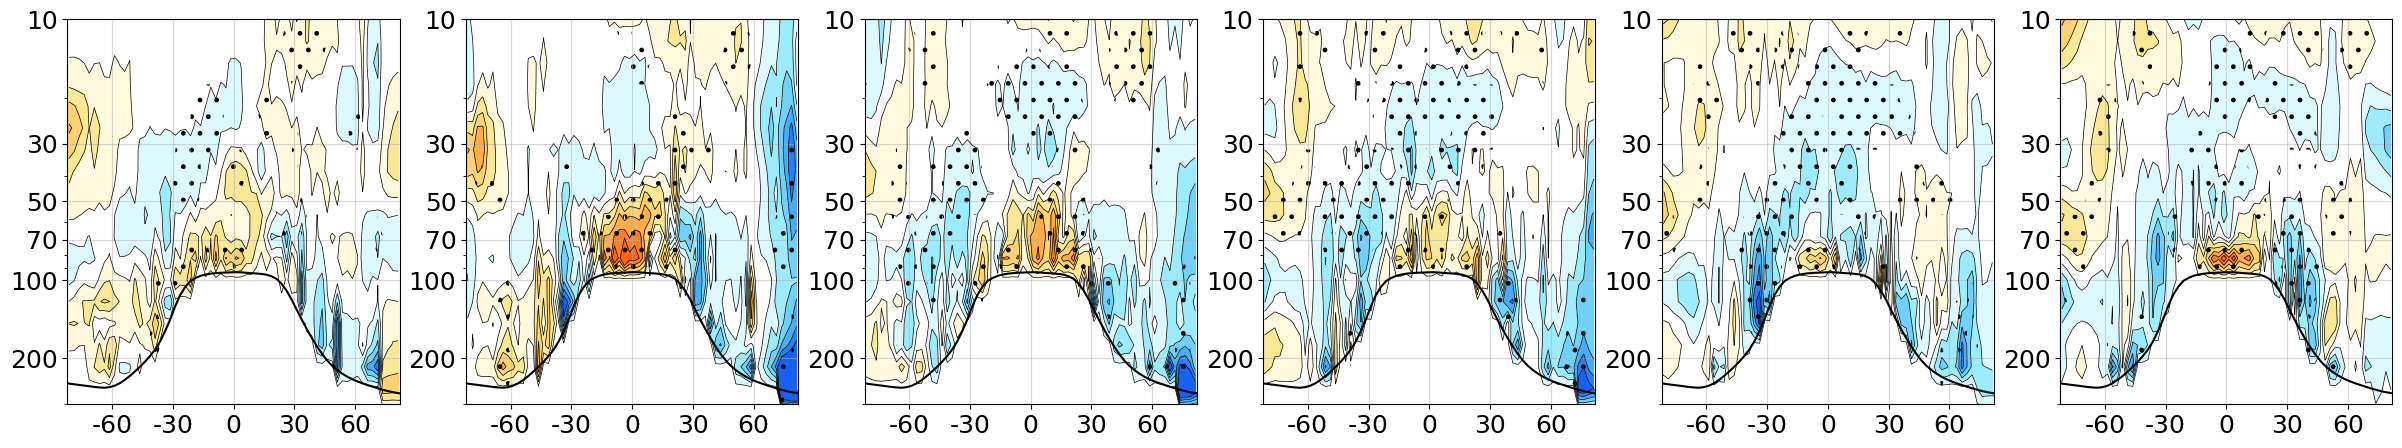

In [41]:
# only plot six months at a time
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

# define levels as 20x the levels for the annual circulation regression
levels = np.arange(-0.55, 0.551,.1)*20

# create plot
fig, axs = plt.subplots(1,6, figsize=(30,5))
axes = axs.ravel()

# select part of year to plot, and trends, circ regr, or difference
months = months1
plot_idx = 0

for x in range(len(months)):
    # select data and significance
    data = months[x][:,:,plot_idx,0]
    significance = months[x][:,:,plot_idx,1]
    
    # zero data below tropopause
    data_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 0, data)
    significance_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 0, significance)
    
    # plot data and significance, and tropopause
    axes[x].contour(o3_data.lat, o3_data.level, data_masked, levels=levels,colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(o3_data.lat, o3_data.level,  data_masked, levels=levels,cmap=custom_cmap, extend='both')
    axes[x].contourf(o3_data.lat, o3_data.level, significance_masked, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axes[x].plot(o3_data.lat, lrp_o3lats, color='black')
    
    # fix plotting
    axes[x].set_yscale('log')
    axes[x].invert_yaxis()

    # set limits
    axes[x].set_ylim(300,10)
    axes[x].set_xlim(-80,80)
    
    # grids 
    axes[x].grid(alpha=0.5)
    x_vals = [-60, -30, 0, 30, 60]
    axes[x].set_xticks(x_vals)
    axes[x].set_xticklabels([str(year) for year in x_vals])
    y_vals = [200,100,70,50,30,10]
    axes[x].set_yticks(y_vals)
    axes[x].set_yticklabels([str(year) for year in y_vals])
    axes[x].tick_params(axis='both', which='major', labelsize=18)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCircRegrJanJun', dpi=300)

# Get monthly correlation

In [42]:
jan  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 0)
feb  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 1)
mar  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 2)
apr  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 3)
may  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 4)
jun  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 5)
jul  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 6)
aug  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 7)
sep  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 8)
occ  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 9)
nov  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 10)
dec  = toolbox.monthly_corr_map(o3_anoms_No_QBO_ENSO_sxx, awls, 11)

/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/TrendAnalysis/toolbox.py:483: RuntimeWarning: invalid value encountered in sqrt
  t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))


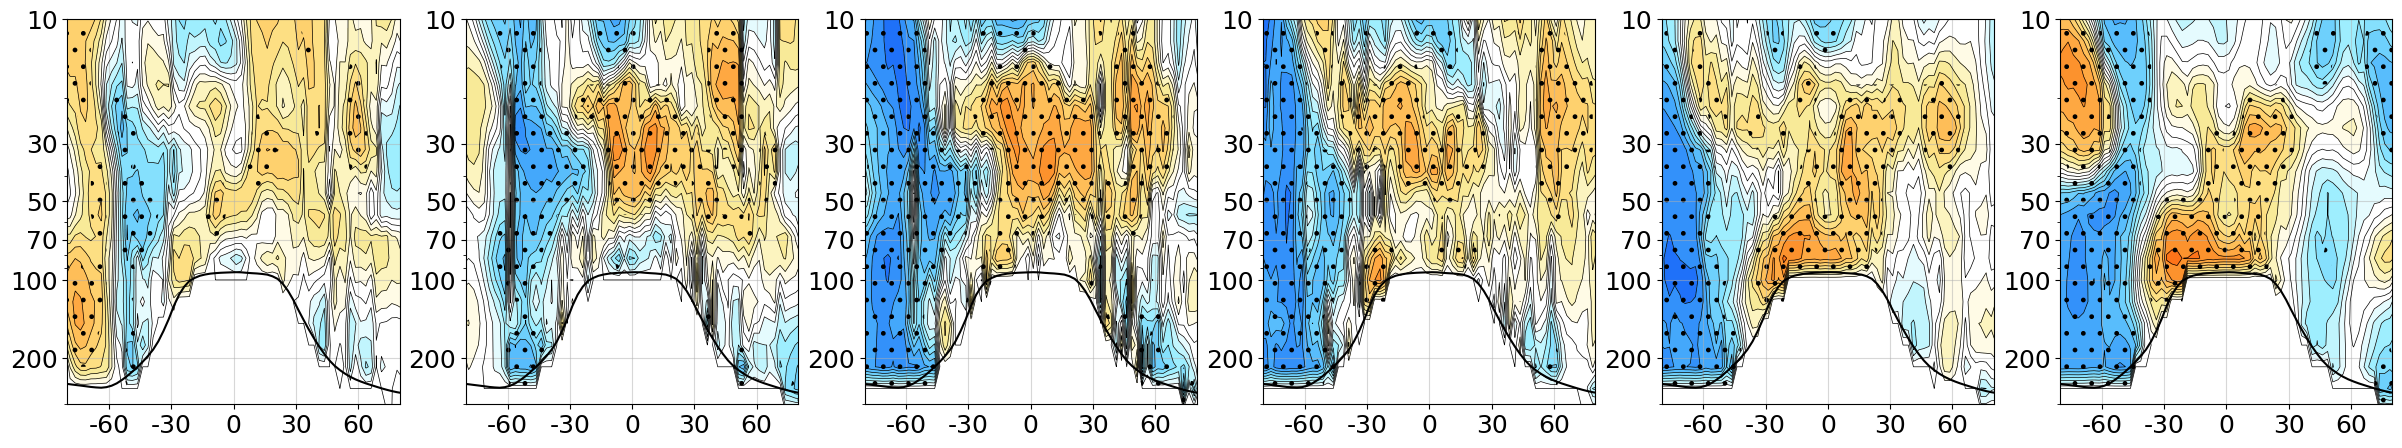

In [46]:
# only plot six months at a time
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

# define levels as for correlation
levels = np.arange(-1,1.01,.1)

# create plot
fig, axs = plt.subplots(1,6, figsize=(30,5))
axes = axs.ravel()

# select part of year to plot
months = months2

for x in range(len(months)):
    # select data and significance
    data = months[x][:,:,0]
    significance = months[x][:,:,1]
    
    # zero data below tropopause
    data_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 0, data)
    significance_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 0, significance)
    
    # plot data and significance, and tropopause
    axes[x].contour(o3_data.lat, o3_data.level, data_masked, levels=levels,
                    colors='black', extend='both', linewidths=0.5, 
                    linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(o3_data.lat, o3_data.level,  data_masked, levels=levels,
                     cmap=custom_cmap, extend='both')
    axes[x].contourf(o3_data.lat, o3_data.level, significance_masked, levels=[-1, 0, 1], 
                     colors='none', hatches=[None,'.'])
    axes[x].plot(o3_data.lat, lrp_o3lats, color='black')
    
    # fix plotting
    axes[x].set_yscale('log')
    axes[x].invert_yaxis()

    # set limits
    axes[x].set_ylim(300,10)
    axes[x].set_xlim(-80,80)
    
    # grids 
    axes[x].grid(alpha=0.5)
    x_vals = [-60, -30, 0, 30, 60]
    axes[x].set_xticks(x_vals)
    axes[x].set_xticklabels([str(year) for year in x_vals])
    y_vals = [200,100,70,50,30,10]
    axes[x].set_yticks(y_vals)
    axes[x].set_yticklabels([str(year) for year in y_vals])
    axes[x].tick_params(axis='both', which='major', labelsize=18)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCircRegrJanJun', dpi=300)

# Preform analysis on abreviated data


In [19]:
# find total time to subselect
total_time = np.linspace(2002 + 1/24, 2023 - 1/24, 252)

# create mask to subselect data based on timeperiod of interest
time_mask = (total_time < 2005) | (total_time > 2019)

# copy ENSO and QBO removed anomalies
o3_time_mask = o3_anoms_No_QBO_ENSO_sxx.copy()

# apply mask to subselect data
o3_time_mask[time_mask,:,:] = np.NaN


In [20]:
# do circulation projection
projection_timeseries, map_sig = toolbox.annual_circ_regr(o3_time_mask, awls)
projection_timeseries = np.swapaxes(projection_timeseries, 0,2)
projection_timeseries = np.swapaxes(projection_timeseries, 1,2)
residual = o3_time_mask - projection_timeseries

#find trends
map_of_trends = toolbox.annual_trend_finder(o3_time_mask)
map_of_trends_projection = toolbox.annual_trend_finder(projection_timeseries)
map_of_trends_residual = toolbox.annual_trend_finder(residual)

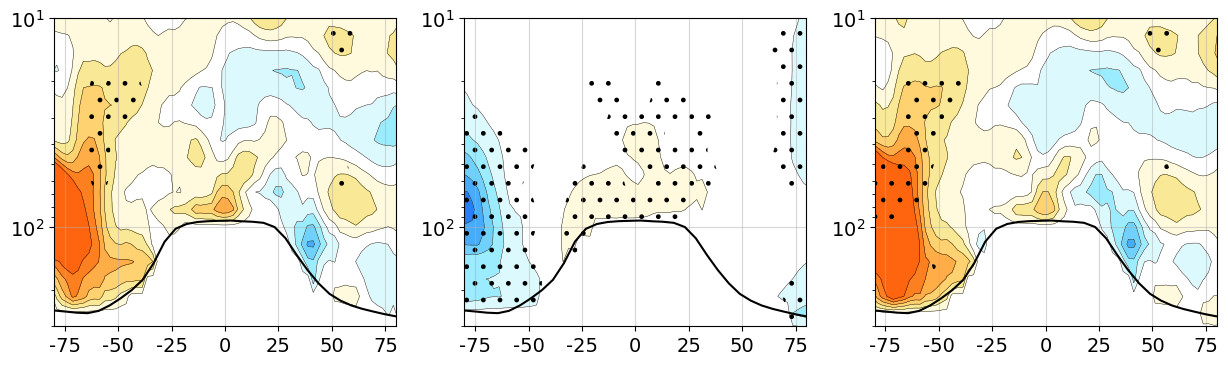

In [21]:
# set contour levels
levels = np.arange(-0.55,0.551,.1)*10

# define subplots
fig, axs = plt.subplots(1,3, figsize=(15,4))

# zero data below tropopause
trends_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                         0, map_of_trends[:,:,0])
trends_sig_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                             0, map_of_trends[:,:,1])
proj_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                       0, map_of_trends_projection[:,:,0])
proj_sig_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                           0, map_sig)
resid_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                        0, map_of_trends_residual[:,:,0])
resid_sig_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 
                            0, map_of_trends_residual[:,:,1])

# plot trends
axs[0].contour(o3_data.lat, o3_data.level, trends_masked, levels=levels, 
               colors='black', extend='both', linewidths=0.3, linestyles=np.where(levels >= 0, "-", "-"))
im = axs[0].contourf(o3_data.lat, o3_data.level, trends_masked, levels=levels, 
                     cmap=custom_cmap, extend='both')
axs[0].contourf(o3_data.lat, o3_data.level, trends_sig_masked, levels=[-1, 0, 1], 
                colors='none', hatches=[None,'.'])

# circulation regression
axs[1].contour(o3_data.lat, o3_data.level, proj_masked, levels=levels, 
               colors='black', extend='both', linewidths=0.3, linestyles=np.where(levels >= 0, "-", "-"))
axs[1].contourf(o3_data.lat, o3_data.level, proj_masked, levels=levels, 
                cmap=custom_cmap, extend='both')
axs[1].contourf(o3_data.lat, o3_data.level, proj_sig_masked, levels=[-1, 0, 1], 
                colors='none', hatches=[None,'.'])

# residual
axs[2].contour(o3_data.lat, o3_data.level, resid_masked, levels=levels, 
               colors='black', extend='both', linewidths=0.3, linestyles=np.where(levels >= 0, "-", "-"))
axs[2].contourf(o3_data.lat, o3_data.level, resid_masked, levels=levels, 
                cmap=custom_cmap, extend='both')
axs[2].contourf(o3_data.lat, o3_data.level, resid_sig_masked, levels=[-1, 0, 1], 
                colors='none', hatches=[None,'.'])

# for each subplot, fix plotting range, include lrz, etc...
for i in range(3):
    #rect = patches.Rectangle((-33.75, 80.), 15, 20, linewidth=2, edgecolor='red', facecolor='none')
    #axs[i].add_patch(rect)
    axs[i].set_xlim(-80,80)
    axs[i].set_yscale('log')
    axs[i].invert_yaxis()
    axs[i].plot(np.linspace(-90,90,36), lrp, color='black')
    axs[i].set_ylim(300,10)
    axs[i].grid(alpha=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    x_vals = [-75, -50, -25, 0, 25, 50, 75]
    axs[i].set_xticks(x_vals)
    axs[i].set_xticklabels([str(year) for year in x_vals])

    
#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCirculationRegression_SAM', dpi=300)

In [22]:
# perform monthly circulation regression
jan  = toolbox.monthly_circ_regr(o3_time_mask, awls, 0)
feb  = toolbox.monthly_circ_regr(o3_time_mask, awls, 1)
mar  = toolbox.monthly_circ_regr(o3_time_mask, awls, 2)
apr  = toolbox.monthly_circ_regr(o3_time_mask, awls, 3)
may  = toolbox.monthly_circ_regr(o3_time_mask, awls, 4)
jun  = toolbox.monthly_circ_regr(o3_time_mask, awls, 5)
jul  = toolbox.monthly_circ_regr(o3_time_mask, awls, 6)
aug  = toolbox.monthly_circ_regr(o3_time_mask, awls, 7)
sep  = toolbox.monthly_circ_regr(o3_time_mask, awls, 8)
occ  = toolbox.monthly_circ_regr(o3_time_mask, awls, 9)
nov  = toolbox.monthly_circ_regr(o3_time_mask, awls, 10)
dec  = toolbox.monthly_circ_regr(o3_time_mask, awls, 11)

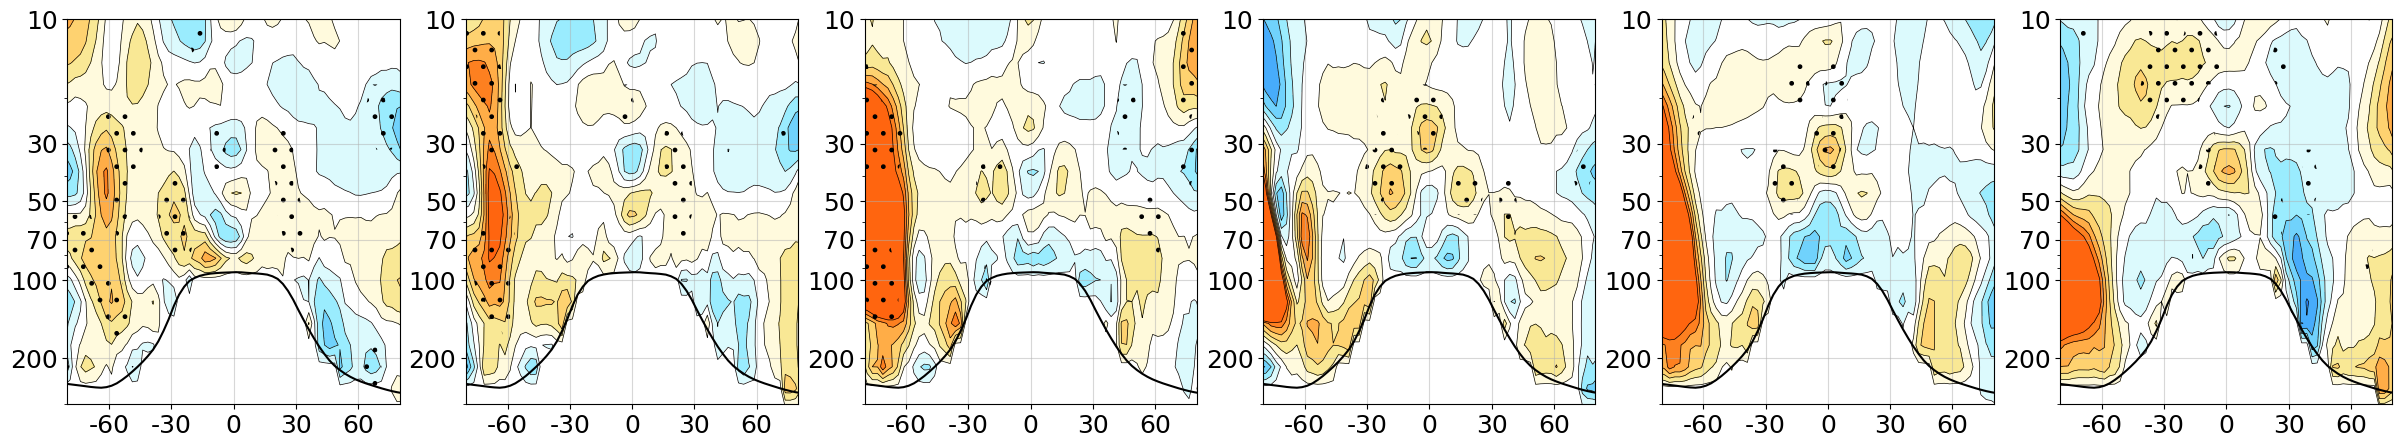

In [23]:
# only plot six months at a time
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

# define levels as 20x the levels for the annual circulation regression
levels = np.arange(-0.55, 0.551,.1)*20

# create plot
fig, axs = plt.subplots(1,6, figsize=(30,5))
axes = axs.ravel()

# select part of year to plot, and trends, circ regr, or difference
months = months2
plot_idx = 0

for x in range(len(months)):
    # select data and significance
    data = months[x][:,:,plot_idx,0]
    significance = months[x][:,:,plot_idx,1]
    
    # zero data below tropopause
    data_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 0, data)
    significance_masked = np.where(o3_data.level.values[:, None] > lrp_o3lats[None, :], 0, significance)
    
    # plot data and significance, and tropopause
    axes[x].contour(o3_data.lat, o3_data.level, data_masked, levels=levels,colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(o3_data.lat, o3_data.level,  data_masked, levels=levels,cmap=custom_cmap, extend='both')
    axes[x].contourf(o3_data.lat, o3_data.level, significance_masked, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axes[x].plot(o3_data.lat, lrp_o3lats, color='black')
    
    # fix plotting
    axes[x].set_yscale('log')
    axes[x].invert_yaxis()

    # set limits
    axes[x].set_ylim(300,10)
    axes[x].set_xlim(-80,80)
    
    # grids 
    axes[x].grid(alpha=0.5)
    x_vals = [-60, -30, 0, 30, 60]
    axes[x].set_xticks(x_vals)
    axes[x].set_xticklabels([str(year) for year in x_vals])
    y_vals = [200,100,70,50,30,10]
    axes[x].set_yticks(y_vals)
    axes[x].set_yticklabels([str(year) for year in y_vals])
    axes[x].tick_params(axis='both', which='major', labelsize=18)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCircRegrJanJun', dpi=300)

# create plots similar to Wang et al., 2024

In [ ]:
monthly_trend = np.concatenate([months1, months2], axis=0)
monthly_trends_antarctic = monthly_trend[:,:,2:10,:,:]
weights = np.cos(np.deg2rad(o3_data.lat[2:10].values))
monthly_trends_antarctic_weighted = np.multiply(monthly_trends_antarctic, weights[np.newaxis,np.newaxis,:,np.newaxis,np.newaxis])
monthly_trends_antarctic = np.nanmean(monthly_trends_antarctic_weighted, axis=2)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [ ]:
np.shape(monthly_trends_antarctic)

(12, 31, 3, 2)

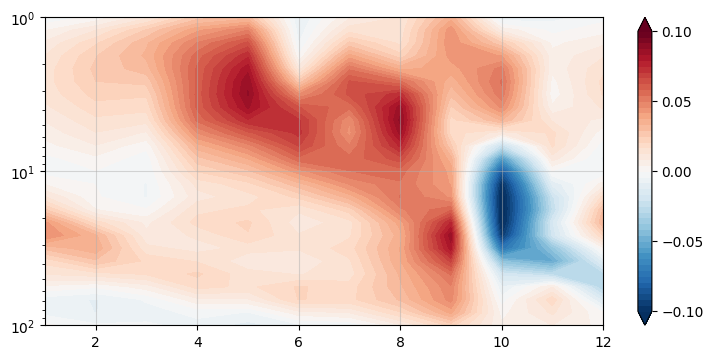

In [ ]:
fig, axs = plt.subplots(figsize=(9,4))
months = np.arange(1,13)
levels = np.arange(-0.3,0.301,0.0125)/3
#levels = np.arange(-3,3.001,.3)*2.5e-2
im = plt.contourf(months, o3_data.level, monthly_trends_antarctic[:,:,0,0].T, levels=levels,cmap='RdBu_r', extend='both')
cbar = plt.colorbar(im, ticks = [-0.1, -0.05, 0, 0.05, 0.1])
#plt.contourf(months, o3_data.level, monthly_trends_antarctic[:,:,0,1].T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

plt.yscale('log')
plt.gca().invert_yaxis()
#plt.title('Trend (2005-2018)')
plt.ylim(100,1)
plt.grid(alpha=0.5)

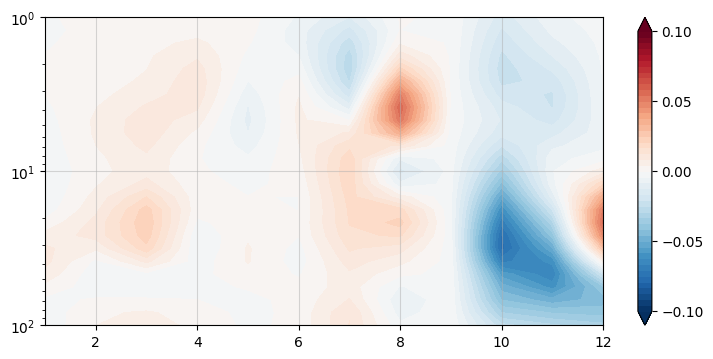

In [ ]:
fig, axs = plt.subplots(figsize=(9,4))
months = np.arange(1,13)
levels = np.arange(-0.3,0.301,0.0125)/3
#levels = np.arange(-3,3.001,.3)*2.5e-2
im = plt.contourf(months, o3_data.level, monthly_trends_antarctic[:,:,1,0].T, levels=levels,cmap='RdBu_r', extend='both')
cbar = plt.colorbar(im, ticks = [-0.1, -0.05, 0, 0.05, 0.1])
#plt.contourf(months, o3_data.level, monthly_trends_antarctic[:,:,0,1].T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

plt.yscale('log')
plt.gca().invert_yaxis()
#plt.title('Trend (2005-2018)')
plt.ylim(100,1)
plt.grid(alpha=0.5)

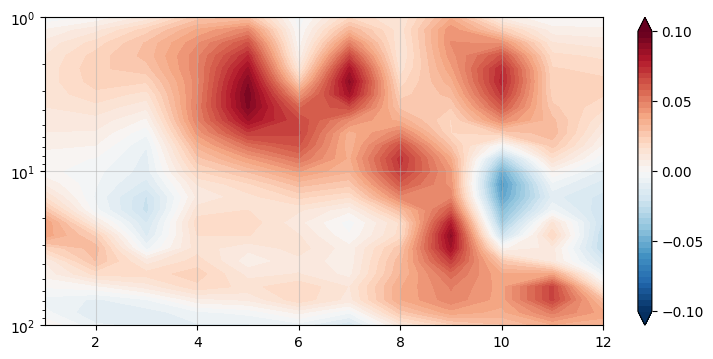

In [ ]:
fig, axs = plt.subplots(figsize=(9,4))
months = np.arange(1,13)
levels = np.arange(-0.3,0.301,0.0125)/3
#levels = np.arange(-3,3.001,.3)*2.5e-2
im = plt.contourf(months, o3_data.level, monthly_trends_antarctic[:,:,2,0].T, levels=levels,cmap='RdBu_r', extend='both')
cbar = plt.colorbar(im, ticks = [-0.1, -0.05, 0, 0.05, 0.1])
#plt.contourf(months, o3_data.level, monthly_trends_antarctic[:,:,0,1].T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

plt.yscale('log')
plt.gca().invert_yaxis()
#plt.title('Trend (2005-2018)')
plt.ylim(100,1)
plt.grid(alpha=0.5)